# Unrealistic high performance come from decoys similarity between different targets

### import common use modules

In [2]:
import os
import sys
import json
import argparse
import numpy as np
import scipy.sparse as sp
from scipy.spatial import distance
import itertools
from multiprocessing import Pool

from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn import metrics
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

### Fuctions for DUD-E loading

In [3]:
def mol_to_fp(m):
    # radius 2 MorganFingerprint equal ECFP4
    fp = AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024)
    return fp

def load_smiles(names, datadir='./', iid=False):
    all_fps = []
    all_labels = []
    ws = []
    # print("Loading data set ...")
    for name in names:
        file_name = os.path.join(datadir, name)
        activeFile = os.path.join(file_name, 'actives_final.ism')
        decoyFile = os.path.join(file_name, 'decoys_final.ism')
        fpf = os.path.join(file_name, 'fp.npz')
        labelf = os.path.join(file_name, 'label.npz')
        if os.path.exists(fpf):
            # print("Reloading data set {} ...".format(fpf))
            fps = sp.load_npz(fpf)
            labels = sp.load_npz(labelf)
        else:
            # print("Loading smiles {} ...".format(activeFile))
            active = [m for m in Chem.SmilesMolSupplier(activeFile, titleLine=False) if m is not None]
            # print("Loading smiles {} ...".format(decoyFile))
            decoy = [m for m in Chem.SmilesMolSupplier(decoyFile, titleLine=False) if m is not None]
            labels = sp.csr_matrix(np.hstack((np.ones(len(active)), np.zeros(len(decoy)))))
            ms = np.hstack((active, decoy))
            # print("Computing figerprints ...")
            with Pool() as p:
                fps = sp.csr_matrix(p.map(mol_to_fp, ms))
            #names = np.array([m.GetProp('_Name') for m in ms])
            sp.save_npz(fpf, fps)
            sp.save_npz(labelf, labels)
        labels = np.squeeze(labels.toarray())
        if iid:
            fps, labels = indepen_indent_distr(fps[labels==1])
        all_fps.append(fps)
        all_labels.append(labels)
        X = sp.vstack(all_fps)
        y = np.hstack(all_labels)
    return X, y

### Fingerprint distance and similarity

In [4]:
def jaccard(a,b):
    ab = a.dot(b.T)[0,0]
    return  1.0 - ab / (a.sum()+b.sum()-ab)

def fps2dist(X, Y):
    X = X.toarray().astype(np.bool)
    Y = Y.toarray().astype(np.bool)
    dist = pairwise_distances(X=X, Y=Y, metric="jaccard", n_jobs=-1)
    return dist

def closest(targetI, targetJ, ax=None, decoy_times=None, decoy_ax=None):
    """get targetI active-decoy most similar: max_ad.
    targetI-targetJ active-active most similar: max_aa.
    targetI-targetJ decoy-decoy most similar: max_dd.
    """
    print("test:{}-train:{}".format(targetI, targetJ))
    max_ad = []
    for i, ti in enumerate(targetI):
        fpi, yi = load_smiles([ti], datadir=data_dir)
        ai = fpi[yi==1]
        max_aid = []
        for j, tj in enumerate(targetI):
            fpj,yj = load_smiles([tj], datadir=data_dir)
            dj = fpj[yj==0]
            dist_aidi = 1. - fps2dist(ai, dj)
            max_aidi = dist_aidi.max(axis=1)
            max_aid.append(max_aidi)
        max_ad.append(np.max(max_aid, axis=0))
    adlist = np.hstack(max_ad)
    sns.kdeplot(adlist, label="test_active-decoy_test",  color='k', ax=ax)
    if decoy_ax:
        sns.kdeplot(adlist, label="test_active-decoy_test",  color='k', ax=decoy_ax)
    max_aa = []
    max_dd = []
    max_ad = []
    max_da = []
    # need max_aa and max_dd with increase targetJ, so targetJ first.
    for j, tj in enumerate(targetJ):
        fpj, yj = load_smiles([tj], datadir=data_dir)
        aj = fpj[yj==1]
        dj = fpj[yj==0]
        if decoy_times:
            dj = dj[np.random.choice(dj.shape[0], int(aj.shape[0] * decoy_times))]
        max_aaj = []
        max_ddj = []
        max_adj = []
        max_daj = []
        for i, ti in enumerate(targetI):
            fpi,yi = load_smiles([ti], datadir=data_dir)
            ai = fpi[yi==1]
            di = fpi[yi==0]
            if decoy_times:
                di = di[np.random.choice(di.shape[0], int(ai.shape[0] * decoy_times))]
            dist_aiaj = 1. - fps2dist(ai, aj)
            max_aiaj = dist_aiaj.max(axis=1)
            max_aaj.append(max_aiaj)
            dist_didj = 1. - fps2dist(di, dj)
            max_didj = dist_didj.max(axis=1)
            max_ddj.append(max_didj)
            dist_aidj = 1. - fps2dist(ai, dj)
            max_aidj = dist_aidj.max(axis=1)
            max_adj.append(max_aidj)
            dist_diaj = 1. - fps2dist(di, aj)
            max_diaj = dist_diaj.max(axis=1)
            max_daj.append(max_diaj)
        max_aa.append(np.hstack(max_aaj))
        max_dd.append(np.hstack(max_ddj))
        max_ad.append(np.hstack(max_adj))
        max_da.append(np.hstack(max_daj))
    if decoy_ax:
        # show decoy-decoy with increment train targets
        decoy_ax.set_title("test:{}-train (incremental)".format(targetI))
        decoy_ax.set_xlabel("Tanimoto coefficient of most similar test-train compound pairs")
        decoy_ax.set_ylabel("Density")
        decoy_ax.set_ylim(0,15)
        decoy_ax.set_xlim(0,1)
        max_dd = np.array(max_dd)
        for j, tj  in enumerate(targetJ):
            ddlist = np.max(max_dd[:j+1], axis=0)
            sns.kdeplot(ddlist,
                        label="test_decoy-decoy_train +[{}]".format(tj), ax=decoy_ax)
    aalist = np.max(max_aa, axis=0)
    adlist = np.max(max_ad, axis=0)
    dalist = np.max(max_da, axis=0)
    ddlist = np.max(max_dd, axis=0)
    sns.kdeplot(aalist, label="test_active-active_train", ax=ax)
    sns.kdeplot(adlist, label="test_active-decoy_train", ax=ax)
    sns.kdeplot(dalist, label="test_decoy-active_train", ax=ax)
    sns.kdeplot(ddlist, label="test_decoy-decoy_train", ax=ax)
    ax.set_title("test:{}-train:{}".format(targetI, targetJ))
    ax.set_xlabel("Tanimoto coefficient of most similar test-train compound pairs")
    ax.set_ylabel("Density")
    ax.set_ylim(0,15)
    ax.set_xlim(0,1)
    return fig

### Load diverse subset (8 targets) of DUD-E

In [ ]:
data_dir="./all"
fold_file="./2split/diverse.json"
with open(fold_file) as f:
    folds = json.load(f)
    if type(folds) is list:
        folds = {i:fold for i,fold in enumerate(folds)}
targets = [i for k, fold in folds.items() for i in fold]
print(targets)

['akt1', 'ampc', 'cp3a4', 'cxcr4', 'gcr', 'hivpr', 'hivrt', 'kif11']


### 8-fold cross-validation show model has high cross targets performance. 

target|AUC_ROC|AUC_PRC|EF 0.5%| EF 1%
---|---|---|---|---
akt1|0.9000178428789278|0.22465608321821498|20.477815699658702|19.11262798634812
ampc|**0.5740497076023392**|0.034562218403073046|8.333333333333332|6.249999999999999
cp3a4|0.8392572283150548|0.15588977711859212|21.176470588235293|16.470588235294116
cxcr4|0.9018349970640047|0.1453970497552569|5.0|17.5
gcr|0.8242306593049356|0.07528886045177878|9.30232558139535|9.30232558139535
hivpr|0.8115109591900636|0.09097606658275278|14.552238805970148|11.380597014925373
hivrt|0.7554237498899792|0.07186358859565306|10.650887573964496|8.579881656804734
kif11|0.7615630505914927|0.03983135042831609|1.7241379310344829|0.8620689655172414
average|0.7959860243545996|0.10480812431920472|11.402151189198975|11.182261180035615

### Show decoys similarity with density plot

In order to investigate the similarity between test set and training set, we compute the similarity between:
```
test_actives --- test_decoys
      |    \_____/     |
      |    /     \     |
train_actives    train_decoys
```
For each compound in first set, we pair it with its most similar compound in second set.
By counting the Tc (Tanimoto coefficient) of most similar compound pairs, we draw a density plot as follows.

The similarity between test decoys and train decoys is much higher than other combinations.
For each targets, those have higher similarity on decoys have better performance, like cxcr4 (AUC_ROC 0.902).

ampc has lowest similarity, so the performance is worest (AUC_ROC 0.574).

test:['akt1']-train:['ampc', 'cp3a4', 'cxcr4', 'gcr', 'hivpr', 'hivrt', 'kif11']
test:['ampc']-train:['akt1', 'cp3a4', 'cxcr4', 'gcr', 'hivpr', 'hivrt', 'kif11']
test:['cp3a4']-train:['akt1', 'ampc', 'cxcr4', 'gcr', 'hivpr', 'hivrt', 'kif11']
test:['cxcr4']-train:['akt1', 'ampc', 'cp3a4', 'gcr', 'hivpr', 'hivrt', 'kif11']
test:['gcr']-train:['akt1', 'ampc', 'cp3a4', 'cxcr4', 'hivpr', 'hivrt', 'kif11']
test:['hivpr']-train:['akt1', 'ampc', 'cp3a4', 'cxcr4', 'gcr', 'hivrt', 'kif11']
test:['hivrt']-train:['akt1', 'ampc', 'cp3a4', 'cxcr4', 'gcr', 'hivpr', 'kif11']
test:['kif11']-train:['akt1', 'ampc', 'cp3a4', 'cxcr4', 'gcr', 'hivpr', 'hivrt']


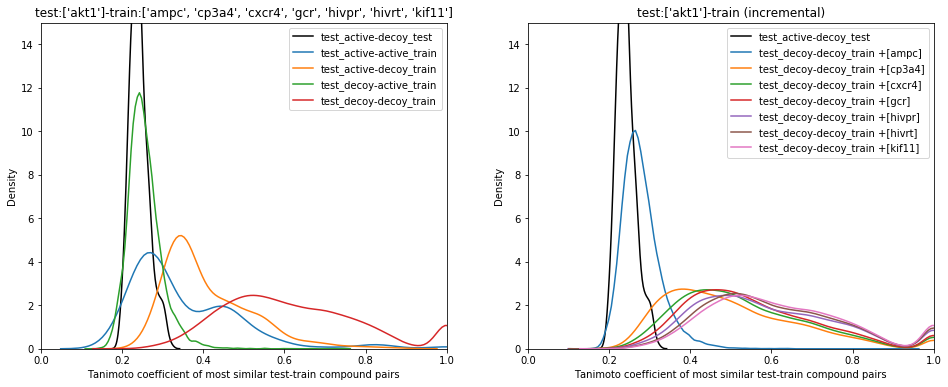

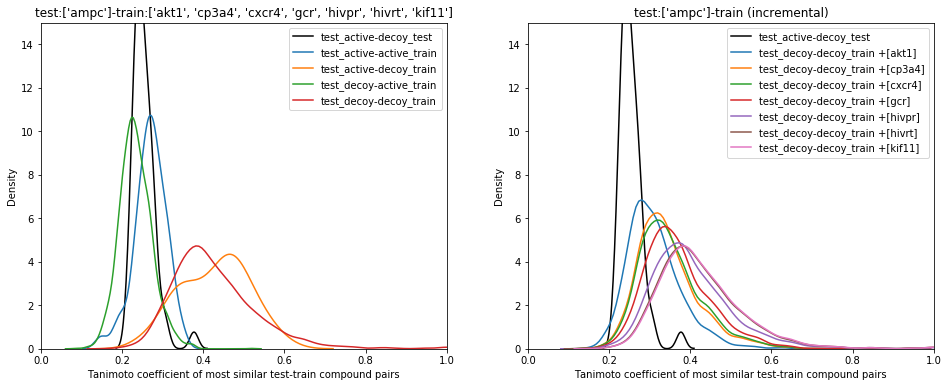

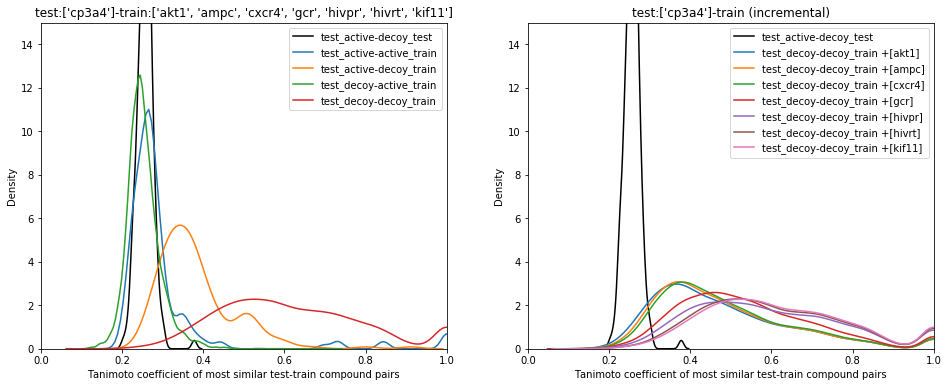

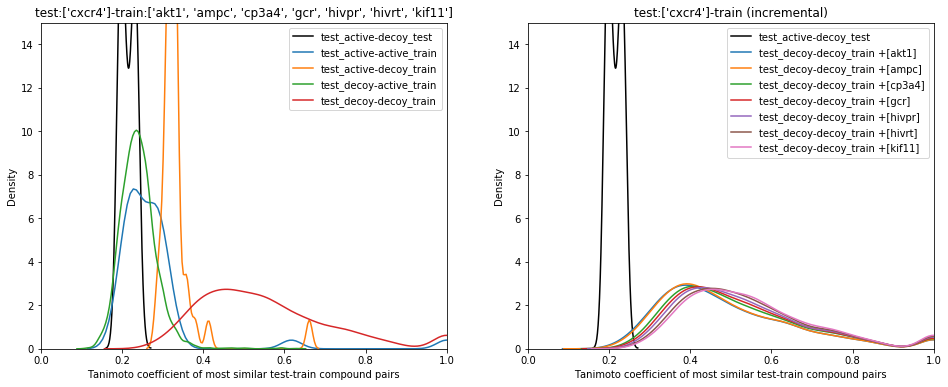

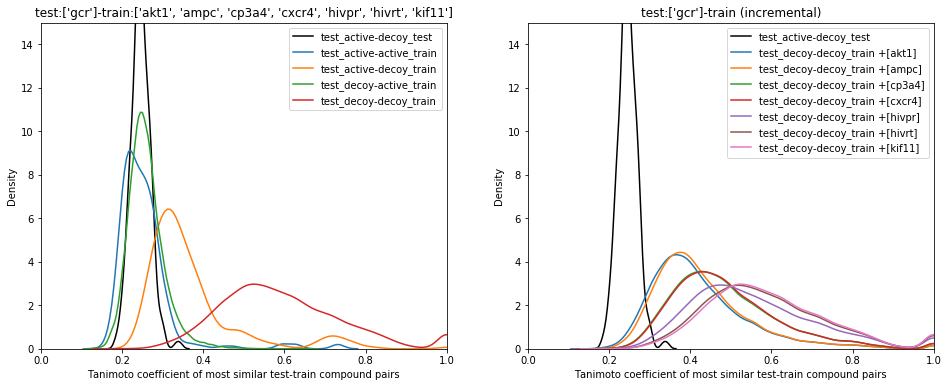

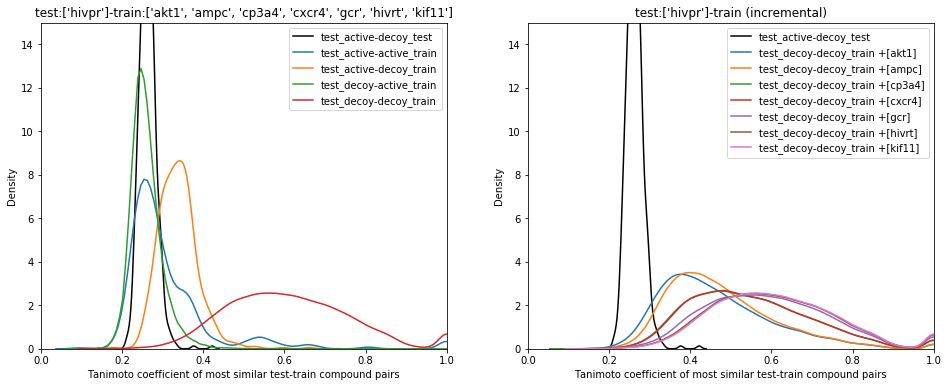

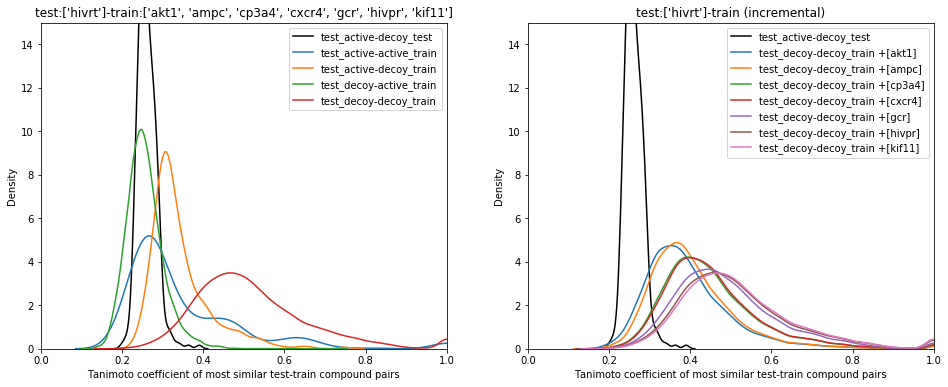

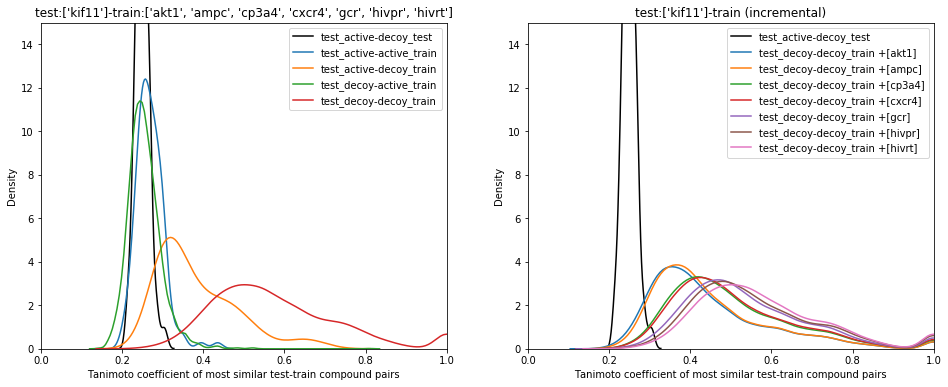

In [ ]:
for i in targets:
    js = []
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    ax, decoy_ax = axes
    js = [j for j in targets if j != i]
    closest([i], js, ax=ax, decoy_ax=decoy_ax)

The similarity of decoys may cause by the size of decoys set is much bigger than the actives set, so I randomly pick a subset of decoys with same size of actives set.

It still show a similar trend.

test:['akt1']-train:['ampc', 'cp3a4', 'cxcr4', 'gcr', 'hivpr', 'hivrt', 'kif11']
test:['ampc']-train:['akt1', 'cp3a4', 'cxcr4', 'gcr', 'hivpr', 'hivrt', 'kif11']
test:['cp3a4']-train:['akt1', 'ampc', 'cxcr4', 'gcr', 'hivpr', 'hivrt', 'kif11']
test:['cxcr4']-train:['akt1', 'ampc', 'cp3a4', 'gcr', 'hivpr', 'hivrt', 'kif11']
test:['gcr']-train:['akt1', 'ampc', 'cp3a4', 'cxcr4', 'hivpr', 'hivrt', 'kif11']
test:['hivpr']-train:['akt1', 'ampc', 'cp3a4', 'cxcr4', 'gcr', 'hivrt', 'kif11']
test:['hivrt']-train:['akt1', 'ampc', 'cp3a4', 'cxcr4', 'gcr', 'hivpr', 'kif11']
test:['kif11']-train:['akt1', 'ampc', 'cp3a4', 'cxcr4', 'gcr', 'hivpr', 'hivrt']


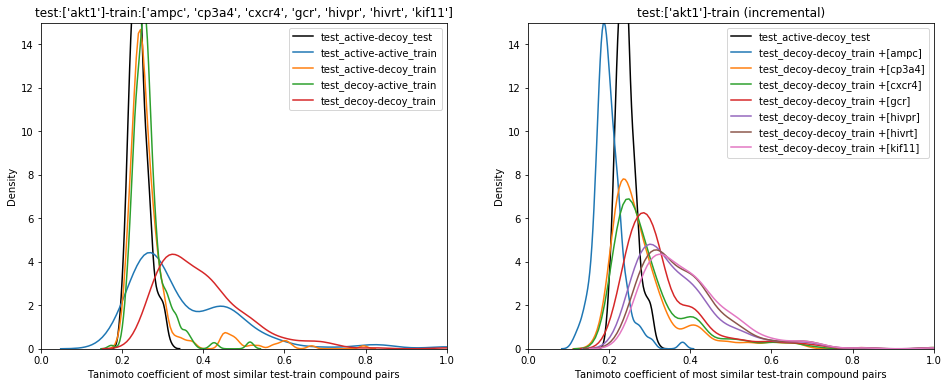

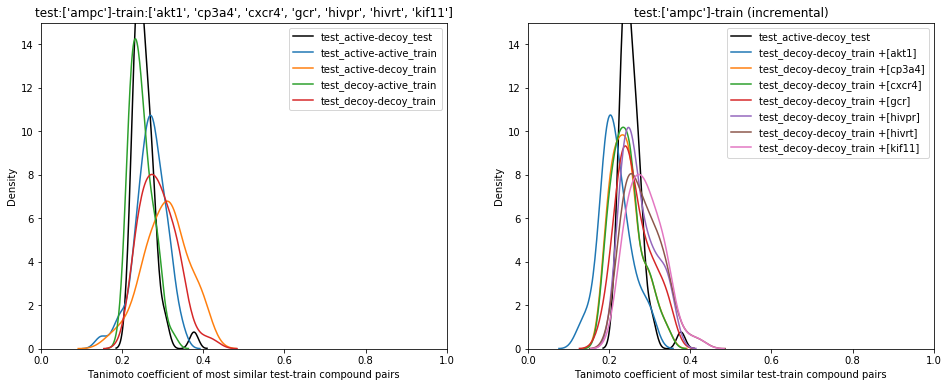

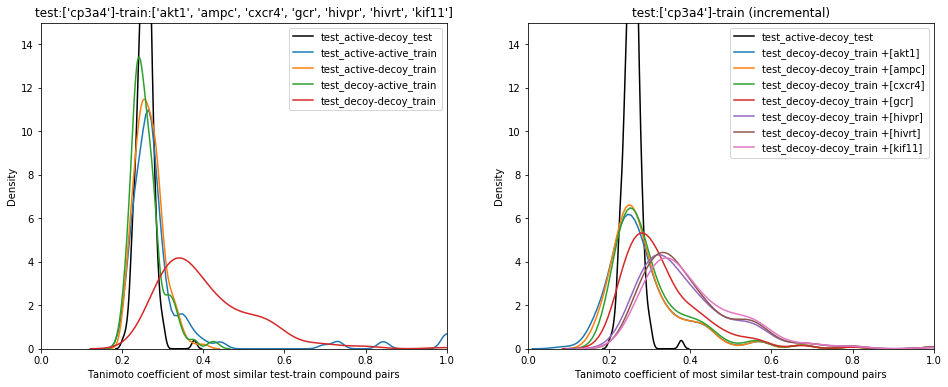

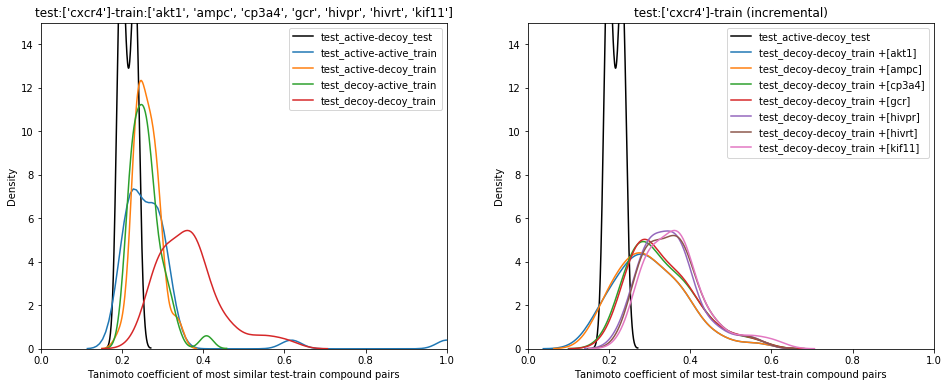

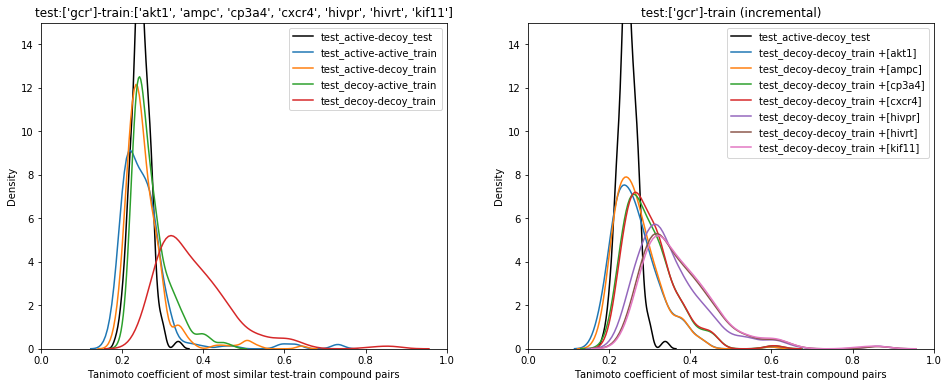

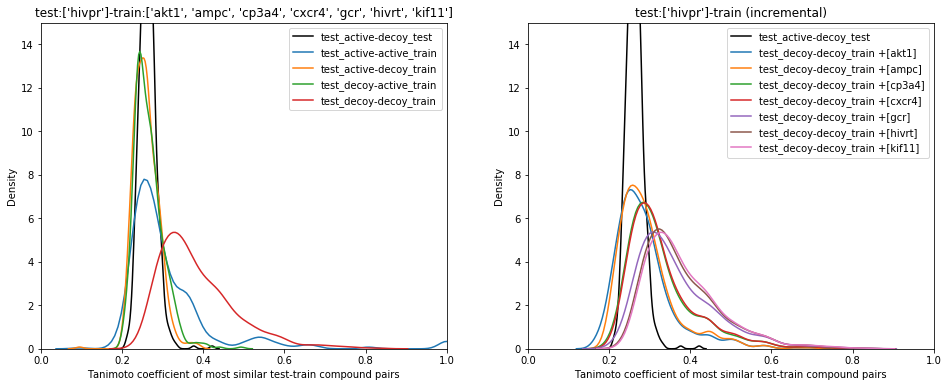

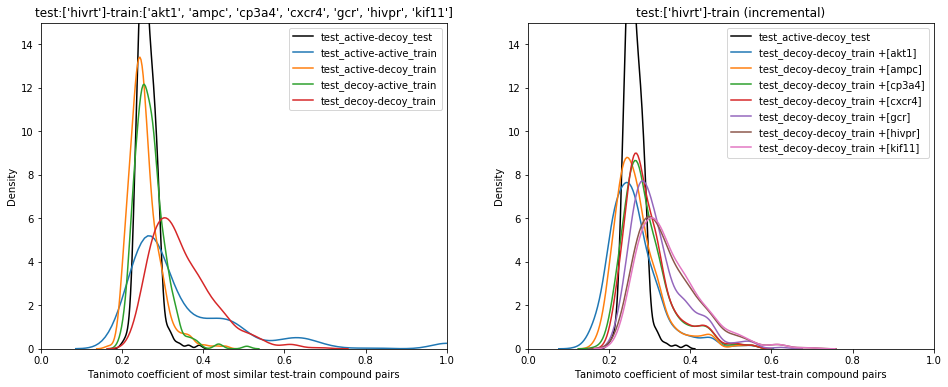

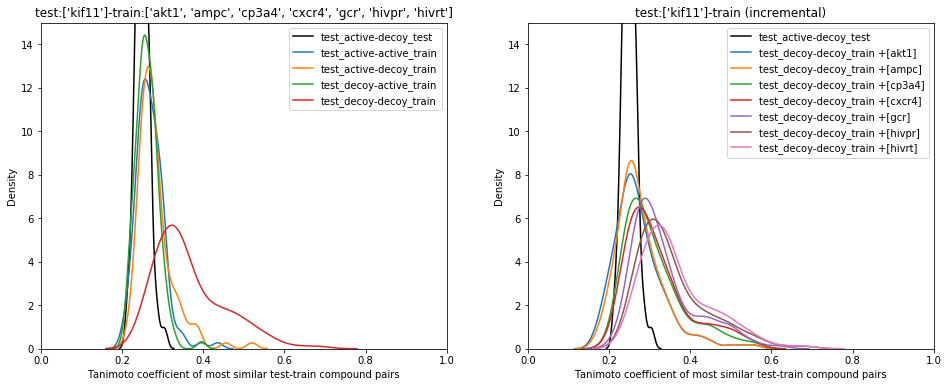

In [25]:
for i in targets:
    js = []
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    ax, decoy_ax = axes
    js = [j for j in targets if j != i]
    closest([i], js, ax=ax, decoy_times=1, decoy_ax=decoy_ax)